In [1]:
import pandas as pd
from glob import glob
import librosa as lr
import numpy as np
import matplotlib.pyplot as plt

#### Inspecting the classification data
- The first is a collection of heartbeat sounds. Hearts normally have a predictable sound pattern as they beat, but some disorders can cause the heart to beat abnormally.

In [2]:
train_set = '../data/set_b/'
train_files = glob(train_set+'*.wav')
# include only normal and murmur
train_files = [file for file in train_files if 'normal' in file or 'murmur' in file]
# filter noisy normal and noisy murmur
audio_files = [file for file in train_files if not 'noisymurmur' in file or 'nosiynormal' in file]
audio_files[:10]

['../data/set_b\\murmur__112_1306243000964_A.wav',
 '../data/set_b\\murmur__112_1306243000964_B.wav',
 '../data/set_b\\murmur__112_1306243000964_D.wav',
 '../data/set_b\\murmur__116_1306258689913_A.wav',
 '../data/set_b\\murmur__116_1306258689913_C.wav',
 '../data/set_b\\murmur__116_1306258689913_D.wav',
 '../data/set_b\\murmur__122_1306325762831_C.wav',
 '../data/set_b\\murmur__122_1306325762831_D.wav',
 '../data/set_b\\murmur__156_1306936373241_B.wav',
 '../data/set_b\\murmur__160_1307100683334_A.wav']

In [3]:
# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

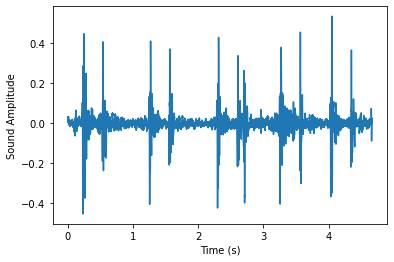

In [4]:
# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time,audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

##### Conclusion : There are several seconds of heartbeat sounds in here, though note that most of this time is silence. A common procedure in machine learning is to separate the datapoints with lots of stuff happening from the ones that don't.

### Inspecting the regression data
- dataset contains information about company market value over several years of time. This is one of the most popular kind of time series data used for regression. If we can model the value of a company as it changes over time, we can make predictions about where that company will be in the future.

In [5]:
# Read in the data
data = pd.read_csv('../data/prices.csv', index_col=0)
data_1 = data[data['symbol'].str.contains('V')]
data_2 = data[data['symbol'].str.contains('AAPL')]
data_3 = data[data['symbol'].str.contains('NFLX')]
data_4 = data[data['symbol'].str.contains('XOM')]
# data_5 = data[data['symbol'].str.contains('FB')]
data = pd.concat([data_1, data_2, data_3, data_4], axis=0)
print(data.symbol.unique())
data = data.drop(['volume'], axis=1)
data.head()

['NVDA' 'V' 'VZ' 'AAPL' 'NFLX' 'XOM']


,symbol,close
date,,
2010-01-04,NVDA,18.490000
2010-01-04,V,88.139999
2010-01-04,VZ,33.279869
2010-01-05,NVDA,18.760000
2010-01-05,V,87.129997


In [6]:
data = data.pivot_table('close','date', 'symbol')
data

symbol,AAPL,NFLX,NVDA,V,VZ,XOM
date,,,,,,
2010-01-04,214.009998,53.479999,18.490000,88.139999,33.279869,69.150002
2010-01-05,214.379993,51.510001,18.760000,87.129997,33.339868,69.419998
2010-01-06,210.969995,53.319999,18.879999,85.959999,31.919873,70.019997
2010-01-07,210.580000,52.400001,18.510000,86.760002,31.729875,69.800003
2010-01-08,211.980005,53.300002,18.549999,87.000000,31.749874,69.519997
...,...,...,...,...,...,...
2016-12-23,116.519997,125.589996,109.779999,78.150002,53.680000,90.709999
2016-12-27,117.260002,128.350006,117.320000,78.349998,53.639999,90.750000
2016-12-28,116.760002,125.889999,109.250000,78.300003,53.439999,90.300003


symbol            AAPL       NFLX       NVDA          V         VZ        XOM
date                                                                         
2010-01-04  214.009998  53.479999  18.490000  88.139999  33.279869  69.150002
2010-01-05  214.379993  51.510001  18.760000  87.129997  33.339868  69.419998
2010-01-06  210.969995  53.319999  18.879999  85.959999  31.919873  70.019997
2010-01-07  210.580000  52.400001  18.510000  86.760002  31.729875  69.800003
2010-01-08  211.980005  53.300002  18.549999  87.000000  31.749874  69.519997
AAPL
NFLX
NVDA
V
VZ
XOM


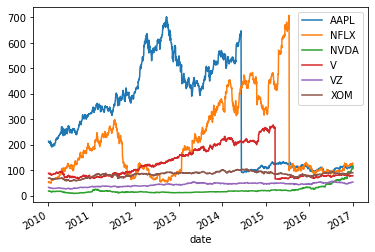

In [7]:
# Convert the index of the DataFrame to datetime
data.index = pd.to_datetime(data.index)
print(data.head())

# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in data.columns:
    print(column)
    data[column].plot(ax=ax, label=column)
ax.legend()
plt.show()

##### Conclusion : Note that each company's value is sometimes correlated with others, and sometimes not. Also note there are a lot of 'jumps' in there - what effect do we think these jumps would have on a predictive model?

### Simple classification
- start with perhaps the simplest classification technique: averaging across dimensions of a dataset and visually inspecting the result.
- use the heartbeat data.Some recordings are normal heartbeat activity, while others are abnormal activity. Let's see if we can spot the difference.

In [8]:
with pd.HDFStore('../data/audio_munged.hdf5') as hdf:
    # This prints a list of all group names:
    print(hdf.keys())

['/h5io/key_data', '/h5io/key_meta']


In [9]:
df = pd.read_hdf('../data/audio_munged.hdf5', '/h5io/key_data')
df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-0.024684,-0.024507,0.008254,-0.000995,0.000281,-0.030747,0.002953,0.005497,-0.000950,0.013836,...,0.073388,0.008799,-0.361737,-0.000501,0.025458,-0.001609,-0.005471,-0.003371,-0.003332,-0.005799
0.000454,-0.060429,-0.047736,0.014809,-0.003381,0.000381,-0.060250,0.003034,0.010088,-0.003243,0.036587,...,0.150714,0.017107,-0.651842,-0.004710,0.053362,-0.004319,-0.011112,-0.004309,-0.007769,-0.010838


In [10]:
normal = df[[3,4,6]]
normal.head(2)

,3,4,6
time,,,
0.000000,-0.000995,0.000281,0.002953
0.000454,-0.003381,0.000381,0.003034


In [11]:
abnormal = df[[0,1,2]]
abnormal.head(2)

,0,1,2
time,,,
0.000000,-0.024684,-0.024507,0.008254
0.000454,-0.060429,-0.047736,0.014809


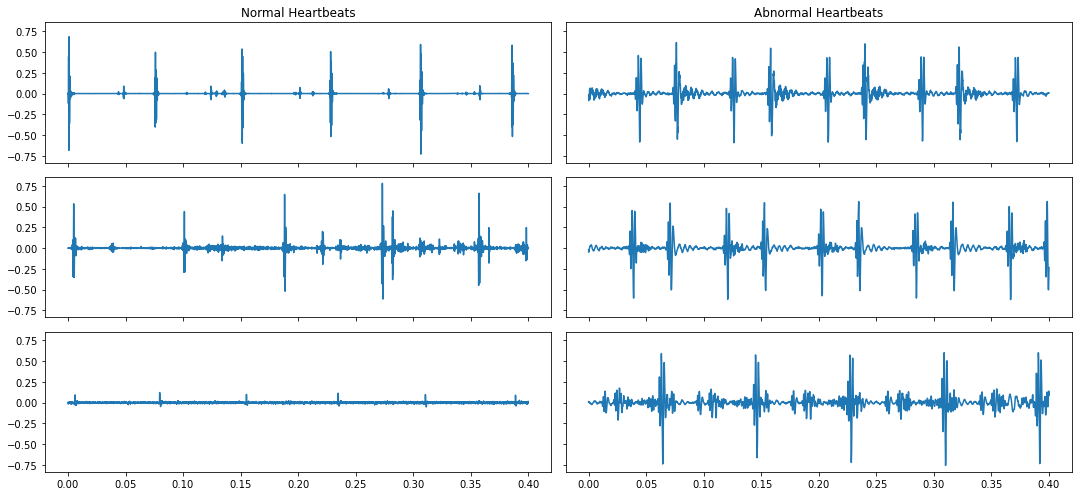

In [12]:
def show_plot_and_make_titles():
    axs[0, 0].set(title="Normal Heartbeats")
    axs[0, 1].set(title="Abnormal Heartbeats")
    plt.tight_layout()
    plt.show()
    
fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(len(normal)) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
show_plot_and_make_titles()

##### Conclusion : As we can see there is a lot of variability in the raw data, let's see if we can average out some of that noise to notice a difference.

### Invariance in time
- While we should always start by visualizing your raw data, this is often uninformative when it comes to discriminating between two classes of data points. Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.
- Another common technique to find simple differences between two sets of data is to average across multiple instances of the same class. This may remove noise and reveal underlying patterns (or, it may not).
- Task : average across many instances of each class of heartbeat sound. 

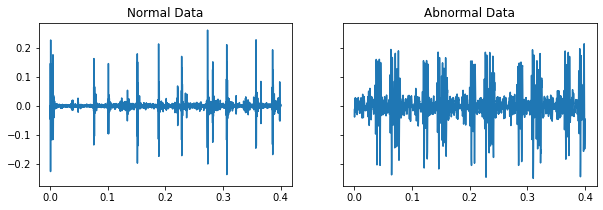

In [13]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data")
plt.show()

##### Conclusion : Do we see a noticeable difference between the two? Maybe, but it's quite noisy. Let's see how we can dig into the data a bit further.

### Build a classification model
- While eye-balling differences is a useful way to gain an intuition for the data, let's see if we can operationalize things with a model. 
- We will use each repetition as a datapoint, and each moment in time as a feature to fit a classifier that attempts to predict abnormal vs. normal heartbeats using only the raw data. 

In [14]:
from sklearn.model_selection import train_test_split

y_normal = np.full(normal.shape[0], ['normal'])
y_abnormal = np.full(abnormal.shape[0], ['abnormal'])
y = np.concatenate([y_normal, y_abnormal], axis=0)
x = np.concatenate([normal, abnormal], axis=0)

X_train, X_test, y_train, y_test = train_test_split(x, y)

In [15]:
from sklearn.svm import LinearSVC

# Initialize and fit the model
model = LinearSVC()
model.fit(X_train, y_train)

# Generate predictions and score them manually
predictions = model.predict(X_test)
print(sum(predictions == y_test.squeeze()) / len(y_test))

0.4485260770975057


##### Conclusion : Note that our predictions didn't do so well. That's because the features we're using as inputs to the model (raw data) aren't very good at differentiating classes.

### Calculating the envelope of sound
- One of the ways we can improve the features available to our model is to remove some of the noise present in the data. In audio data, a common way to do this is to smooth the data and then rectify it so that the total amount of sound energy over time is more distinguishable. 

In [16]:
audio = df
audio

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
time,,,,,,,,,,,,,,,,,,,,,
0.000000,-0.024684,-0.024507,0.008254,-0.000995,0.000281,-0.030747,0.002953,0.005497,-0.000950,0.013836,...,0.073388,0.008799,-0.361737,-0.000501,0.025458,-0.001609,-0.005471,-0.003371,-0.003332,-0.005799
0.000454,-0.060429,-0.047736,0.014809,-0.003381,0.000381,-0.060250,0.003034,0.010088,-0.003243,0.036587,...,0.150714,0.017107,-0.651842,-0.004710,0.053362,-0.004319,-0.011112,-0.004309,-0.007769,-0.010838
0.000907,-0.070080,-0.039938,0.010475,-0.000948,0.000063,-0.047856,0.000292,0.008272,-0.004097,0.044119,...,0.129426,0.015018,-0.365683,-0.007257,0.050708,0.000573,-0.009940,-0.001084,-0.008644,-0.007528
0.001361,-0.084212,-0.041199,0.010272,-0.000766,0.000026,-0.048017,-0.005916,0.009358,-0.004431,0.053670,...,0.137134,0.017465,-0.173468,-0.005510,0.052555,-0.001807,-0.011539,-0.000613,-0.010337,-0.008523
0.001814,-0.085111,-0.036050,0.008580,0.000469,-0.000432,-0.040114,-0.005307,0.009418,-0.003582,0.060088,...,0.125747,0.018050,0.141141,-0.000892,0.046691,-0.007140,-0.012783,0.000383,-0.011342,-0.008434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.997732,0.010513,-0.401539,0.138510,-0.000089,-0.005931,0.004402,0.002474,0.007786,0.005954,-0.010387,...,0.002659,0.008561,-0.010949,-0.023636,0.000896,-0.004598,0.015704,0.000035,-0.030464,0.008344
3.998186,0.009675,-0.360107,0.134382,-0.000112,-0.004839,0.006493,0.004467,0.008496,0.006834,-0.038993,...,0.004752,0.008938,-0.016313,-0.016825,0.001175,-0.002079,0.014768,0.000261,-0.031350,0.005336
3.998639,0.007957,-0.317170,0.124178,-0.000233,-0.000591,0.009416,0.016809,0.008140,0.008045,-0.066156,...,0.006779,0.008587,-0.009336,-0.009357,0.002574,-0.000979,0.013052,0.000283,-0.030538,0.003226


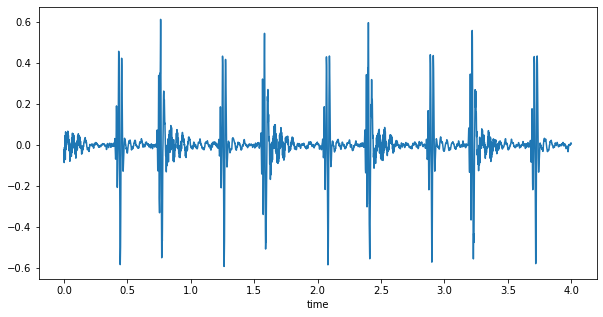

In [17]:
# Plot the raw data first
audio[0].plot(figsize=(10, 5))
plt.show()

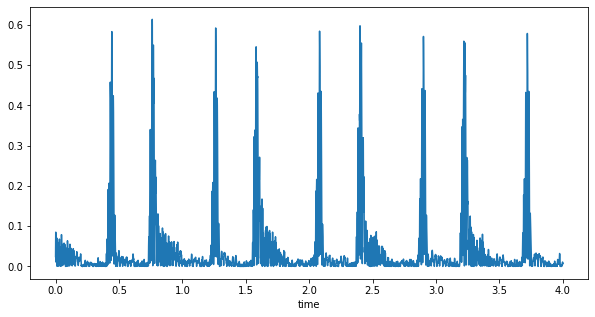

In [18]:
# Rectify the audio signal
audio_rectified = audio.apply(np.abs)

# Plot the result
audio_rectified[0].plot(figsize=(10, 5))
plt.show()

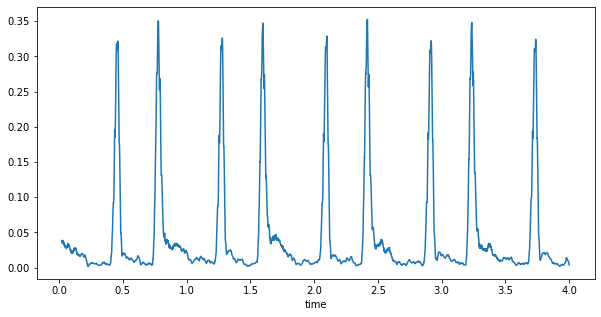

In [19]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean()

# Plot the result
audio_rectified_smooth[0].plot(figsize=(10, 5))
plt.show()

##### Conclusion : By calculating the envelope of each sound and smoothing it, we've eliminated much of the noise and have a cleaner signal to tell us when a heartbeat is happening.

### Calculating features from the envelope
-  We've removed some of the noisier fluctuations in the audio, let's see if this improves your ability to classify. 

#### Create labels array

In [20]:
df_labels = pd.read_hdf('../data/audio_munged.hdf5', '/h5io/key_meta')
# y_train = df_labels[df_labels['set']=='train']['label']
# y_test = df_labels[df_labels['set']=='test']['label']

labels = np.array(df_labels['label'])

In [124]:
means1 = np.mean(audio_rectified_smooth, axis=1)
means1.shape

(8820,)

In [21]:
# Calculate stats
means = np.mean(audio_rectified_smooth, axis=0)
stds = np.std(audio_rectified_smooth, axis=0)
maxs = np.max(audio_rectified_smooth, axis=0)

# Create the X and y arrays
X = np.column_stack([means, stds, maxs])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
from sklearn.model_selection import cross_val_score
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.7166666666666667


C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  ret

##### Conclusion : This model is both simpler (only 3 features) and more understandable (features are simple summary statistics of the data).

### Derivative features: The tempogram
- One benefit of cleaning up our data is that it lets us compute more sophisticated features. For example, the envelope calculation we performed is a common technique in computing **tempo** and **rhythm** features. 
-  use **librosa** to compute some tempo and rhythm features for heartbeat data, and fit a model once more.
- Note that librosa functions tend to **only operate on numpy arrays instead of DataFrames**, so we'll access our Pandas data as a Numpy array with the `.values` attribute.

In [22]:
# Calculate the tempo of the sounds
tempos = []
for col, i_audio in audio.items():
    tempos.append(lr.beat.tempo(i_audio.values, sr=sfreq, hop_length=2**6, aggregate=None))

# Convert the list to an array so you can manipulate it more easily
tempos = np.array(tempos)

# Calculate statistics of each tempo
tempos_mean = tempos.mean(axis=-1)
tempos_std = tempos.std(axis=-1)
tempos_max = tempos.max(axis=-1)

In [23]:
# Create the X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_std, tempos_max])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.5


C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: D

##### Conclusion : Note that our predictive power may not have gone up (because this dataset is quite small), but we now have a more rich feature representation of audio that our model can use!

### Spectrograms of heartbeat audio
- Spectral engineering is one of the most common techniques in machine learning for time series data. The first step in this process is to calculate a spectrogram of sound. This describes what spectral content (e.g., low and high pitches) are present in the sound over time. 
- Convert the spectogram (spec) to decibels. 
- Visualize the spectrogram

In [51]:
# convert dataframe to numpy array
single_audio = np.array(df[0])
# single_audio = np.asfortranarray(single_audio)

# Import the stft function
from librosa.core import stft

# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(single_audio, hop_length=HOP_LENGTH, n_fft=2**7)

# convert spec to real from complex and convert to non-negative
spec = np.abs(spec.real)

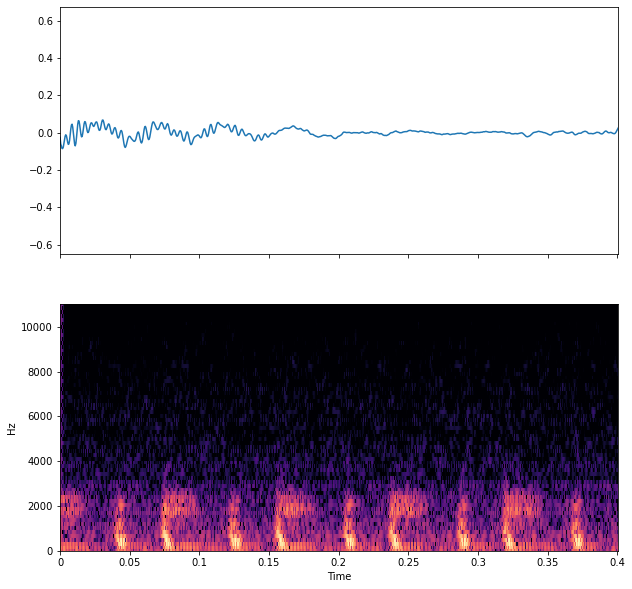

In [52]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert into decibels
spec_db = amplitude_to_db(spec)
time = np.array(df.index)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, single_audio)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
plt.show()

##### Conclusion : Do you notice that the heartbeats come in pairs, as seen by the vertical lines in the spectrogram?

### Engineering spectral features
- There is a lot more information in a spectrogram compared to a raw audio file. By computing the spectral features, we have a much better idea of what's going on. As such, there are all kinds of spectral features that we can compute using the spectrogram as a base.
- Calculate the spectral bandwidth as well as the spectral centroid of the spectrogram by using functions in librosa.feature.
- Convert the spectrogram to decibels for visualization.
- Plot the spectrogram over time.

In [64]:
import librosa as lr

# Calculate the spectral centroid and bandwidth for the spectrogram
bandwidths = lr.feature.spectral_bandwidth(S=spec)[0]
centroids = lr.feature.spectral_centroid(S=spec)[0]

In [96]:
time_spec = spec[:1]
time_spec = np.array(time_spec.ravel())


<class 'matplotlib.collections.QuadMesh'>


AttributeError: 'QuadMesh' object has no attribute 'plot'

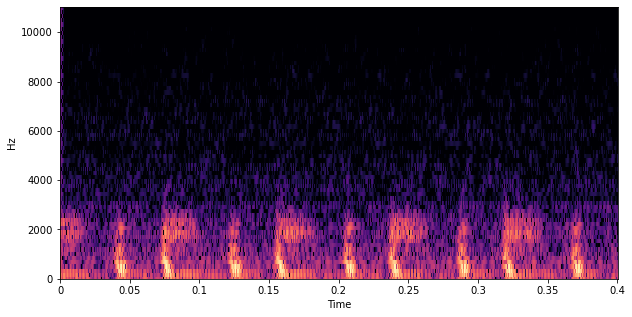

In [100]:
from librosa.core import amplitude_to_db
from librosa.display import specshow

# Convert spectrogram to decibels for visualization
spec_db = amplitude_to_db(spec)

# Display these features on top of the spectrogram
fig, ax = plt.subplots(figsize=(10, 5))
ax = specshow(spec_db, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH)
print(type(ax))
ax.plot(time_spec, centroids)
ax.fill_between(time_spec, centroids - bandwidths / 2, centroids + bandwidths / 2, alpha=.5)
ax.set(ylim=[None, 6000])
plt.show()

### Combining many features in a classifier
- We have engineered many features from the audio data - some contain information about how the audio changes in time, others contain information about the spectral content that is present.
- The beauty of machine learning is that it can handle all of these features at the same time. If there is different information present in each feature, it should improve the classifier's ability to distinguish the types of audio. Note that this often requires more advanced techniques such as **regularization**.
- Combine all the features into an array that can be fed into the classifier, and see how it does.

In [136]:
# calculate specs for all audios
# convert dataframe to numpy array
audio = df.to_numpy()
# single_audio = np.asfortranarray(single_audio)

# Import the stft function
from librosa.core import stft

spectrograms = []
# Prepare the STFT
for single_audio in audio.T:
    HOP_LENGTH = 2**4
    spec = stft(single_audio, hop_length=HOP_LENGTH, n_fft=2**7)

    # convert spec to real from complex and convert to non-negative
    spec = np.abs(spec.real)
    spectrograms.append(spec)

- Loop through each spectrogram, calculating the mean spectral bandwidth and centroid of each.

In [137]:
# Loop through each spectrogram
bandwidths = []
centroids = []

for spec in spectrograms:
    # Calculate the mean spectral bandwidth
    this_mean_bandwidth = np.mean(lr.feature.spectral_bandwidth(S=spec))
#     print(this_mean_bandwidth)
    # Calculate the mean spectral centroid
    this_mean_centroid = np.mean(lr.feature.spectral_centroid(S=spec))
    # Collect the values
    bandwidths.append(this_mean_bandwidth)  
    centroids.append(this_mean_centroid)

- Column stack all the features to create the array X. 
- Score the classifier with cross-validation.

In [139]:
# Create X and y arrays
X = np.column_stack([means, stds, maxs, tempos_mean, tempos_max, tempos_std, bandwidths, centroids])
y = labels.reshape([-1, 1])

# Fit the model and score on testing data
percent_score = cross_val_score(model, X, y, cv=5)
print(np.mean(percent_score))

0.6833333333333333


C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Shubham\Anaconda3\lib\site-packages\sklearn\utils\validation.py:73: D

##### Conclusion : We calculated many different features of the audio, and combined each of them under the assumption that they provide independent information that can be used in classification. We may have noticed that the accuracy of our models varied a lot when using different set of features. We focused on creating new "features" from raw data and not obtaining the best accuracy. To improve the accuracy, we need to find the right features that provide relevant information and also build models on much larger data.

## Regression

- We'll deal with stock market prices that fluctuate over time.We've got historical prices from two tech companies (Ebay and Yahoo) in the data called prices.
- We'll visualize the raw data for the two companies, then generate a scatter plot showing how the values for each company compare with one another. Finally, we'll add in a "time" dimension to our scatter plot so we can see how this relationship changes over time.


In [144]:
prices = pd.read_csv('../data/prices.csv', index_col=['date'])
prices.head(2)

,symbol,close,volume
date,,,
2010-01-04,AAPL,214.009998,123432400.0
2010-01-04,ABT,54.459951,10829000.0


In [147]:
data_1 = prices[prices['symbol'].str.contains('EBAY')]
data_2 = prices[prices['symbol'].str.contains('YHOO')]
data = pd.concat([data_1, data_2])
data = data.drop('volume', axis=1)

data = data.pivot_table('close','date', 'symbol')
data.head(2)

symbol,EBAY,YHOO
date,,
2010-01-04,23.90,17.10
2010-01-05,23.65,17.23


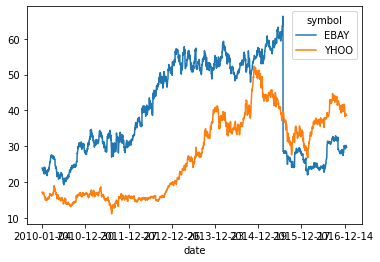

In [149]:
# Plot the raw values over time
data.plot()
plt.show()

- Generate a scatter plot with the values of Ebay on the x-axis, and Yahoo on the y-axis. Look up the symbols for both companies from the column names of the DataFrame.

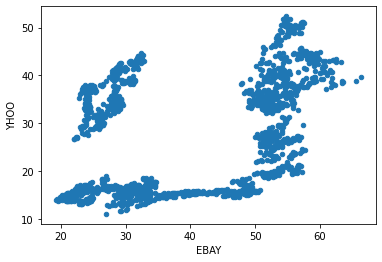

In [151]:
# Scatterplot with one company per axis
data.plot.scatter('EBAY', 'YHOO')
plt.show()

- Finally, encode time as the color of each datapoint in order to visualize how the relationship between these two variables changes.

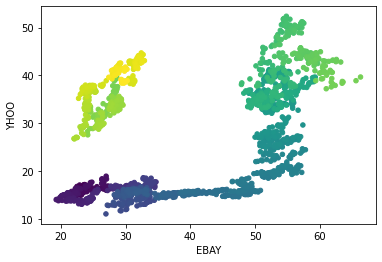

In [160]:
# Scatterplot with color relating to time
data.plot.scatter('EBAY', 'YHOO', c=np.arange(len(data.index)),
                    cmap=plt.cm.viridis, colorbar=False)
plt.show()

##### Conclusion : these two time series seem somewhat related to each other, though its a complex relationship that changes over time.